In [110]:
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
import PIL.Image
from pathlib import Path

from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

import matplotlib.image as mpimg
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

In [112]:
def load_image(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)
    
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    
    return img


def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [135]:
content_image_path = 'images/content_anatoly_1.jpg'
#content_image_path = 'images/content_carina_2.jpg'

#style_image_path = 'images/style_kandinsky_7.jpg'
#style_image_path = 'images/style_warhol_monroe_1.jpg'
#style_image_path = 'images/style_hope_obama.jpeg'
#style_image_path = 'images/style_van_gogh_sternennacht.jpeg'
#style_image_path = 'images/style_impressionist_landscape_1.jpg'
#style_image_path = 'images/style_impressionist_landscape_2.jpg'
#style_image_path = 'images/style_hokusai_great_wave.jpg'
#style_image_path = 'images/style_woman_colorful.jpg'
#style_image_path = 'images/style_picasso_portrait.jpg'
style_image_path = 'images/style_country_road.png'

content_image = load_image(content_image_path)
style_image = load_image(style_image_path)

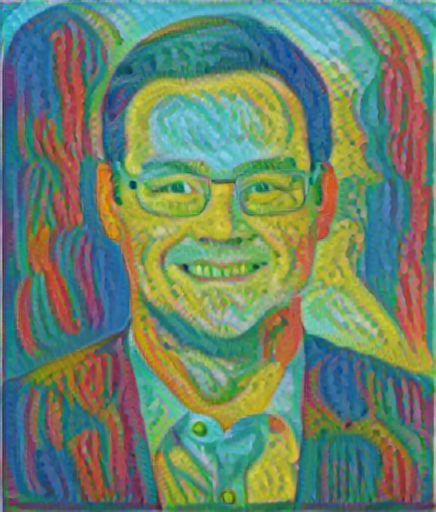

In [136]:
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [18]:
content = mpimg.imread(content_image_path)
content_preprocessed = preprocess_input(content[np.newaxis,...])

In [57]:
content.astype(np.float32).shape

(3024, 4032, 3)

In [63]:
image = content

max_ = np.max(image.shape)
scaling_factor = max_/512.0
target_shape = [int(i/scaling_factor) for i in image.shape[:-1]] + [3]

print(f'Preprocessing image from {image.shape} to {target_shape}')
image  = tf.image.resize(image, target_shape[:-1])

image.shape


Preprocessing image from (3024, 4032, 3) to [384, 512, 3]


TensorShape([384, 512, 3])

In [47]:
class NSTModel():
    
    def __init__(self, content_layers: list, style_layers: list):
        
        base_model = VGG19(include_top=False, weights='imagenet')
        base_model.trainable = False

        if content_layers is None:
            content_layers = ['block5_conv2']

        if style_layers is None:
            style_layers = [
                'block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1'
            ]

        content_outputs = []
        style_outputs = []
    
        self.content_layers = content_layers
        self.style_layers = style_layers
    
        for layer in base_model.layers:
            if layer.name in self.content_layers:
                content_outputs.append(layer.output)
            if layer.name in self.style_layers:
                style_outputs.append(layer.output)
    
        outputs = {'content': content_outputs, 'style': style_outputs}
        model = tf.keras.Model(inputs=base_model.inputs, outputs=outputs)
    
        self.nst_model = model

    def process(self, image: tf.Variable) -> tf.Tensor:

        # THIS IS EXPERIMENTAL:
        image = image/255.0
        image = preprocess_input(image)
        # END EXPERIMENTAL
        
        outputs = self.nst_model(image)

        return outputs

model = NSTModel(content_layers = ['block5_conv2'], style_layers=['block1_conv1'])

In [74]:
model.process(content_image)

{'content': [<tf.Tensor: shape=(1, 24, 32, 512), dtype=float32, numpy=
  array([[[[0.0000000e+00, 0.0000000e+00, 7.9760490e+01, ...,
            0.0000000e+00, 4.7501972e+01, 0.0000000e+00],
           [0.0000000e+00, 0.0000000e+00, 1.9511738e+01, ...,
            0.0000000e+00, 5.5931370e+01, 0.0000000e+00],
           [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
            0.0000000e+00, 4.8606441e+01, 0.0000000e+00],
           ...,
           [0.0000000e+00, 0.0000000e+00, 6.1945105e+00, ...,
            0.0000000e+00, 5.1038025e+01, 0.0000000e+00],
           [0.0000000e+00, 0.0000000e+00, 2.7994299e+01, ...,
            0.0000000e+00, 4.3557507e+01, 0.0000000e+00],
           [0.0000000e+00, 0.0000000e+00, 5.2255824e-02, ...,
            0.0000000e+00, 5.4374168e+01, 0.0000000e+00]],
  
          [[0.0000000e+00, 0.0000000e+00, 6.0511551e+01, ...,
            0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
           [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
       

In [72]:
VGG19().summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [75]:
import ipywidgets as widgets

In [80]:
b = widgets.VBox([widgets.Checkbox(value=False, description='bla')])

In [81]:
type(b.children[0])

ipywidgets.widgets.widget_bool.Checkbox

In [82]:
b.children[0].value=True

In [87]:
with open('test.txt', 'a') as file:
    file.write('\ntest')

In [88]:
import pandas as pd

In [102]:
df = pd.DataFrame({'a': [1, 2, 3], 'b': [4, 5, 6]})
df = df.set_index('a')

In [108]:
df.to_csv('test.csv', mode='a')

In [101]:
df

,a,b
0,1,4
1,2,5
2,3,6


In [109]:
pd.read_csv('test.csv')

,a,b
0,1,4
1,2,5
2,3,6
3,a,b
4,1,4
5,2,5
6,3,6
